In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [36]:

# Чтение данных
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = pd.read_csv('data/SN_ms_tot_V2.0.csv',
                    delimiter=',',
                    header=None,
                    usecols=[0, 1, 3],
                    names=['Year', 'Month', 'Sunspots'])

# Предобработка данных
data['Date'] = data['Year'] + (data['Month'] - 1) / 12
data = data[['Date', 'Sunspots']]
data = data[data['Sunspots'] >= 0]

scaler = MinMaxScaler()
data['Sunspots'] = scaler.fit_transform(data['Sunspots'].values.reshape(-1, 1))


In [37]:

# Создание временных рядов
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)].values
        y = data.iloc[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 12
X, y = create_sequences(data[['Sunspots']], seq_length)

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Конвертация в тензоры
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)


In [ ]:

# Определение модели
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size).to(device),
                            torch.zeros(1, 1, self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        predictions = self.linear(lstm_out[:, -1])
        return predictions


In [38]:

# Инициализация модели, оптимизатора и функции потерь
model = LSTMModel().to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [39]:

# Обучение модели
epochs = 100
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    model.hidden_cell = (torch.zeros(1, X_train.size(0), model.hidden_layer_size).to(device),
                         torch.zeros(1, X_train.size(0), model.hidden_layer_size).to(device))
    y_pred = model(X_train)
    train_loss = loss_function(y_pred, y_train)
    train_loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_function(y_test_pred, y_test)
    
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} Train Loss: {train_loss.item()} Test Loss: {test_loss.item()}')


Epoch 0 Train Loss: 0.17704008519649506 Test Loss: 0.1790519505739212
Epoch 10 Train Loss: 0.049722421914339066 Test Loss: 0.049480196088552475
Epoch 20 Train Loss: 0.036648888140916824 Test Loss: 0.0382714569568634
Epoch 30 Train Loss: 0.0311135184019804 Test Loss: 0.03357675299048424
Epoch 40 Train Loss: 0.02130572870373726 Test Loss: 0.020683834329247475
Epoch 50 Train Loss: 0.008697259239852428 Test Loss: 0.008037043735384941
Epoch 60 Train Loss: 0.006762322038412094 Test Loss: 0.005672491621226072
Epoch 70 Train Loss: 0.005157850682735443 Test Loss: 0.00496102636680007
Epoch 80 Train Loss: 0.004975129384547472 Test Loss: 0.004911365453153849
Epoch 90 Train Loss: 0.004449452273547649 Test Loss: 0.00421645725145936


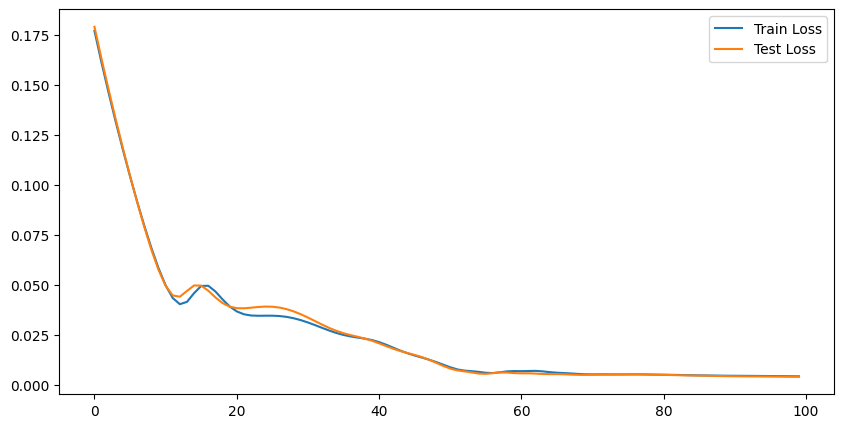

In [40]:

# Визуализация лосса
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()


In [41]:

# Прогнозирование и визуализация результатов
model.eval()
with torch.no_grad():
    train_pred = model(X_train).cpu().numpy()
    test_pred = model(X_test).cpu().numpy()

train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)
y_train_inv = scaler.inverse_transform(y_train.cpu().numpy().reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.cpu().numpy().reshape(-1, 1))


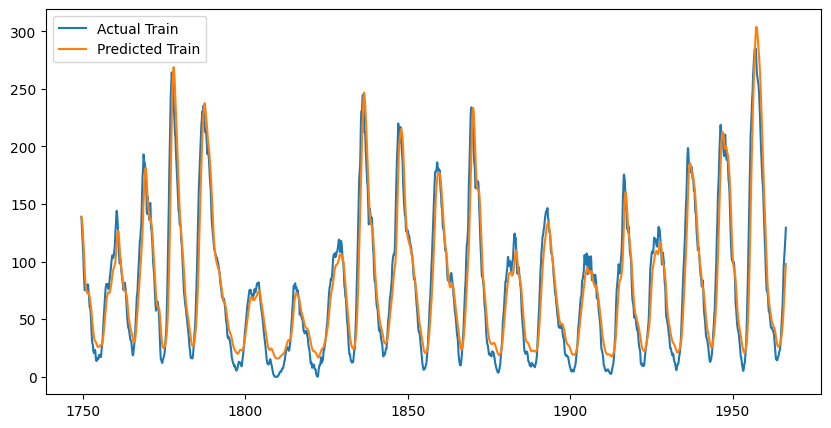

In [42]:

plt.figure(figsize=(10,5))
plt.plot(data['Date'][:len(train_pred)], y_train_inv, label='Actual Train')
plt.plot(data['Date'][:len(train_pred)], train_pred, label='Predicted Train')
plt.legend()
plt.show()


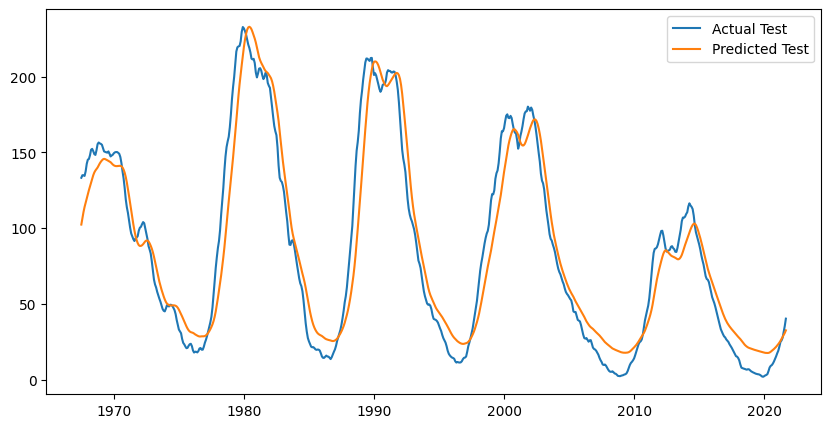

In [43]:

plt.figure(figsize=(10,5))
plt.plot(data['Date'][-len(test_pred):], y_test_inv, label='Actual Test')
plt.plot(data['Date'][-len(test_pred):], test_pred, label='Predicted Test')
plt.legend()
plt.show()


Epoch 0 Loss: 0.0003379070258233696
Epoch 10 Loss: 0.0008286205702461302
Epoch 20 Loss: 0.00046250910963863134
Epoch 30 Loss: 0.00033399826497770846
Epoch 40 Loss: 0.00029457706841640174
Epoch 50 Loss: 0.00030030173365958035
Epoch 60 Loss: 0.00028399823349900544
Epoch 70 Loss: 0.0002776051696855575
Epoch 80 Loss: 0.0002715610899031162
Epoch 90 Loss: 0.0002664564526639879


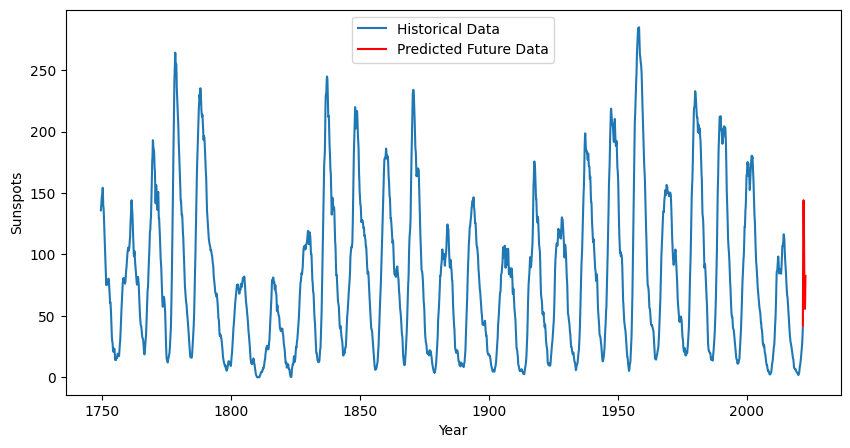

Date: 2021.68, Predicted Sunspots: 41.89
Date: 2021.68, Predicted Sunspots: 45.81
Date: 2021.69, Predicted Sunspots: 49.83
Date: 2021.70, Predicted Sunspots: 53.94
Date: 2021.71, Predicted Sunspots: 58.15
Date: 2021.72, Predicted Sunspots: 62.44
Date: 2021.73, Predicted Sunspots: 66.83
Date: 2021.73, Predicted Sunspots: 71.28
Date: 2021.74, Predicted Sunspots: 75.77
Date: 2021.75, Predicted Sunspots: 80.32
Date: 2021.76, Predicted Sunspots: 84.90
Date: 2021.77, Predicted Sunspots: 89.47
Date: 2021.78, Predicted Sunspots: 93.98
Date: 2021.78, Predicted Sunspots: 98.41
Date: 2021.79, Predicted Sunspots: 102.75
Date: 2021.80, Predicted Sunspots: 106.97
Date: 2021.81, Predicted Sunspots: 111.05
Date: 2021.82, Predicted Sunspots: 114.95
Date: 2021.83, Predicted Sunspots: 118.65
Date: 2021.83, Predicted Sunspots: 122.14
Date: 2021.84, Predicted Sunspots: 125.40
Date: 2021.85, Predicted Sunspots: 128.42
Date: 2021.86, Predicted Sunspots: 131.17
Date: 2021.87, Predicted Sunspots: 133.66
Date: 

In [59]:
DELTA = 12 * 10
# Обучаем модель на всех доступных данных
all_X, all_y = create_sequences(data[['Sunspots']], seq_length)
all_X = torch.tensor(all_X, dtype=torch.float32).to(device)
all_y = torch.tensor(all_y, dtype=torch.float32).to(device)

model.train()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100

for epoch in range(epochs):
    optimizer.zero_grad()
    model.hidden_cell = (torch.zeros(1, all_X.size(0), model.hidden_layer_size).to(device),
                         torch.zeros(1, all_X.size(0), model.hidden_layer_size).to(device))
    y_pred = model(all_X)
    loss = loss_function(y_pred, all_y)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} Loss: {loss.item()}')

# Предсказание на 12 месяцев вперёд
def predict_next_months(model, data, seq_length, months_ahead=DELTA):
    model.eval()
    predictions = []
    current_seq = data[-seq_length:].values
    
    for _ in range(months_ahead):
        with torch.no_grad():
            seq_tensor = torch.tensor(current_seq.reshape(1, seq_length, 1), dtype=torch.float32).to(device)
            next_value = model(seq_tensor).item()
            predictions.append(next_value)
            current_seq = np.append(current_seq[1:], next_value)
    
    return predictions

# Используем последние 12 месяцев данных для предсказания
last_12_months = data[['Sunspots']].tail(seq_length)
future_predictions = predict_next_months(model, last_12_months, seq_length)

# Обратная нормализация предсказанных значений
future_predictions_inv = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Вычисление дат для будущих предсказаний
last_date = data['Date'].iloc[-1]
future_dates = [last_date + (i + 1) / DELTA for i in range(DELTA)]

# Визуализация предсказаний
plt.figure(figsize=(10,5))
plt.plot(data['Date'], scaler.inverse_transform(data[['Sunspots']]), label='Historical Data')
plt.plot(future_dates, future_predictions_inv, label='Predicted Future Data', color='red')
plt.xlabel('Year')
plt.ylabel('Sunspots')
plt.legend()
plt.show()

# Печать предсказанных значений
for date, pred in zip(future_dates, future_predictions_inv):
    print(f"Date: {date:.2f}, Predicted Sunspots: {pred[0]:.2f}")
